# CNN for RSSI + CSI

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

from csidataset import *
import data_loader
from data_loader import *
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import denoise
from model import *

In [2]:
csi_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1223_phone/5G/20MHz/csv/all"
rssi_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/RSSI/timestamp_allignment_Balanced_2024_12_14_rtt_logs.csv"

In [3]:
# Load data CSI
reference_points = {}
spacing = 0.6  # 每隔 0.6m

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(csi_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

data, rp_labels, coord_labels = load_data(reference_points)

In [4]:
data

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,919.592301,929.595611,877.760787,898.203763,851.400023,893.573164,888.473973,871.023536,836.316328,841.770753,...,-1.387518,-1.581549,-1.708760,-2.080869,-2.287379,-2.467120,-2.666997,-2.982241,-50.0,136.0
1,698.204841,732.963846,684.079674,694.257877,651.079872,672.521375,687.674342,780.946221,803.560203,863.103702,...,-2.677159,-2.877730,-3.051501,2.738820,2.503722,2.256683,2.035376,1.737005,-49.0,148.0
2,745.268408,768.188128,706.606680,713.252410,681.482208,713.950278,736.619983,852.877482,846.442556,880.032954,...,0.176051,-0.063704,-0.251636,-0.776139,-1.023850,-1.275624,-1.535994,-1.899522,-50.0,224.0
3,830.278267,829.860832,804.005597,796.492310,786.787138,800.870776,791.982323,778.923616,763.872372,766.167084,...,-1.031820,-1.194379,-1.338067,-1.666445,-1.878363,-2.100073,-2.369892,-2.666982,-51.0,136.0
4,906.099884,903.507056,910.843565,896.688352,892.235955,875.416472,878.300632,854.687077,857.886939,843.664033,...,-0.445534,-0.593750,-0.783166,-1.090942,-1.286103,-1.497279,-1.784787,-2.076610,-50.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24495,397.615392,416.889674,395.588170,413.019370,382.733589,381.136459,393.814677,434.337426,465.842248,483.735465,...,2.183710,2.005190,1.826107,1.364322,1.150287,0.872978,0.573063,0.255977,-56.0,148.0
24496,643.708785,646.260010,627.624888,621.498994,605.152873,628.458431,617.272225,592.763865,581.986254,587.911558,...,-0.494557,-0.782703,-1.053078,-1.631902,-1.969954,-2.328378,-2.758960,3.087458,-59.0,136.0
24497,762.685387,745.553486,706.884007,695.708272,698.951357,710.169698,720.184004,675.370269,654.120020,669.209982,...,0.621717,0.498336,0.356470,-0.131807,-0.426306,-0.748795,-1.031706,-1.339351,-58.0,136.0
24498,401.220638,416.688133,388.561449,390.436935,370.411933,382.498366,394.452786,436.664631,446.643034,495.258518,...,-1.801749,-2.120022,-2.410138,3.138034,2.751942,2.306627,1.868269,1.432071,-56.0,148.0


In [5]:
csi = data

In [6]:
csi["Label"] = rp_labels

In [7]:
csi

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,Label
0,919.592301,929.595611,877.760787,898.203763,851.400023,893.573164,888.473973,871.023536,836.316328,841.770753,...,-1.581549,-1.708760,-2.080869,-2.287379,-2.467120,-2.666997,-2.982241,-50.0,136.0,1
1,698.204841,732.963846,684.079674,694.257877,651.079872,672.521375,687.674342,780.946221,803.560203,863.103702,...,-2.877730,-3.051501,2.738820,2.503722,2.256683,2.035376,1.737005,-49.0,148.0,1
2,745.268408,768.188128,706.606680,713.252410,681.482208,713.950278,736.619983,852.877482,846.442556,880.032954,...,-0.063704,-0.251636,-0.776139,-1.023850,-1.275624,-1.535994,-1.899522,-50.0,224.0,1
3,830.278267,829.860832,804.005597,796.492310,786.787138,800.870776,791.982323,778.923616,763.872372,766.167084,...,-1.194379,-1.338067,-1.666445,-1.878363,-2.100073,-2.369892,-2.666982,-51.0,136.0,1
4,906.099884,903.507056,910.843565,896.688352,892.235955,875.416472,878.300632,854.687077,857.886939,843.664033,...,-0.593750,-0.783166,-1.090942,-1.286103,-1.497279,-1.784787,-2.076610,-50.0,136.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24495,397.615392,416.889674,395.588170,413.019370,382.733589,381.136459,393.814677,434.337426,465.842248,483.735465,...,2.005190,1.826107,1.364322,1.150287,0.872978,0.573063,0.255977,-56.0,148.0,49
24496,643.708785,646.260010,627.624888,621.498994,605.152873,628.458431,617.272225,592.763865,581.986254,587.911558,...,-0.782703,-1.053078,-1.631902,-1.969954,-2.328378,-2.758960,3.087458,-59.0,136.0,49
24497,762.685387,745.553486,706.884007,695.708272,698.951357,710.169698,720.184004,675.370269,654.120020,669.209982,...,0.498336,0.356470,-0.131807,-0.426306,-0.748795,-1.031706,-1.339351,-58.0,136.0,49
24498,401.220638,416.688133,388.561449,390.436935,370.411933,382.498366,394.452786,436.664631,446.643034,495.258518,...,-2.120022,-2.410138,3.138034,2.751942,2.306627,1.868269,1.432071,-56.0,148.0,49


In [8]:
# Load data RSSI

label_to_coordinates_swapped = {
    "1-1":  (0, 0),   "1-2":  (0, 0.6),   "1-3":  (0, 1.2),   "1-4":  (0, 1.8),
    "1-5":  (0, 2.4), "1-6":  (0, 3.0),   "1-7":  (0, 3.6),   "1-8":  (0, 4.2),
    "1-9":  (0, 4.8), "1-10": (0, 5.4),   "1-11": (0, 6.0),

    "2-1":  (0.6, 0),  "2-11": (0.6, 6.0),

    "3-1":  (1.2, 0),  "3-11": (1.2, 6.0),

    "4-1":  (1.8, 0),  "4-11": (1.8, 6.0),

    "5-1":  (2.4, 0),  "5-11": (2.4, 6.0),

    "6-1":  (3.0, 0),  "6-2":  (3.0, 0.6),  "6-3":  (3.0, 1.2),  "6-4":  (3.0, 1.8),
    "6-5":  (3.0, 2.4), "6-6":  (3.0, 3.0),  "6-7":  (3.0, 3.6),  "6-8":  (3.0, 4.2),
    "6-9":  (3.0, 4.8), "6-10": (3.0, 5.4),  "6-11": (3.0, 6.0),

    "7-1":  (3.6, 0),  "7-11": (3.6, 6.0),

    "8-1":  (4.2, 0),  "8-11": (4.2, 6.0),

    "9-1":  (4.8, 0),  "9-11": (4.8, 6.0),

    "10-1": (5.4, 0),  "10-11": (5.4, 6.0),

    "11-1": (6.0, 0),  "11-2": (6.0, 0.6), "11-3": (6.0, 1.2), "11-4": (6.0, 1.8),
    "11-5": (6.0, 2.4),"11-6": (6.0, 3.0), "11-7": (6.0, 3.6), "11-8": (6.0, 4.2),
    "11-9": (6.0, 4.8),"11-10":(6.0, 5.4), "11-11":(6.0, 6.0)
}


coordinates = {
        1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
        36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
        2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
        6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
        12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
        16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
        20: (5.4, 6.0), 21: (6.0, 6.0),
        22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
        26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
        41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
        44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
        47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
    }
coordinate_to_label2 = {value: key for key, value in coordinates.items()}

# label_to_coordinates:  "1-1" -> (0, 0)
# coordinates:          1      -> (0, 0)

# 1) 先建立一個「座標 -> 數字」的反轉字典
coord_to_num = {value: key for key, value in coordinates.items()}
# coord_to_num[(0,0)] = 1,  coord_to_num[(0.6,0)] = 40, ...

# 2) 建立 "1-1" -> 整數標籤 的 map
label_str_to_num = {}
for str_label, coord in label_to_coordinates_swapped.items():
    if coord in coord_to_num:  # 確保在座標字典中找得到
        label_str_to_num[str_label] = coord_to_num[coord]

In [9]:
rssi = pd.read_csv(rssi_path)

rssi = rssi.drop(columns=['timeStemp', 'AP1_Distance (mm)', 'AP2_Distance (mm)', 'AP3_Distance (mm)', 'AP4_Distance (mm)', 'AP1_StdDev (mm)','AP2_StdDev (mm)', 'AP3_StdDev (mm)', 'AP4_StdDev (mm)'])

In [10]:
rssi["Label"]

0        1-11
1        1-11
2        1-11
3        1-11
4        1-11
         ... 
19644     7-1
19645     7-1
19646     7-1
19647     7-1
19648     7-1
Name: Label, Length: 19649, dtype: object

In [11]:
rssi["Label"] = (
    rssi["Label"]
    .map(label_to_coordinates_swapped)   # 由 "1-1" → (0,0)
    .map(coordinate_to_label2)   # 由 (0,0) → 1 (或其他整數標籤)
)


In [12]:
rssi

,Label,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,11,-60.0,-68.0,-61.0,-59.0
1,11,-62.0,-70.0,-59.0,-59.0
2,11,-61.0,-69.0,-62.0,-55.0
3,11,-62.0,-69.0,-63.0,-55.0
4,11,-61.0,-70.0,-62.0,-55.0
...,...,...,...,...,...
19644,35,-64.0,-66.0,-61.0,-58.0
19645,35,-67.0,-75.0,-62.0,-59.0
19646,35,-64.0,-66.0,-61.0,-57.0
19647,35,-66.0,-65.0,-59.0,-58.0


In [13]:
import pandas as pd

# 假設你的 RSSI DataFrame 名叫 df_rssi
# 它至少包含欄位 ["Label", "AP1_Rssi", "AP2_Rssi", ...] 等資訊

target_total = 500  # 每個 Label 期望擁有的筆數
need_extra = 99     # 需要再抽幾筆 (500 - 401 = 99)

all_label_groups = []  # 用來存放每個 label 擴充後的 DataFrame

unique_labels = rssi["Label"].unique()

for label_value in unique_labels:
    sub_df = rssi[rssi["Label"] == label_value].reset_index(drop=True)
    
    # 假設這裡已知 sub_df 長度就是 401；若有需要，你可加檢查:
    # if len(sub_df) != 401:
    #     print(f"Label {label_value} 不等於 401 筆，目前有 {len(sub_df)} 筆。")
    #     # 或視需求做別的處理

    # 從 sub_df 再抽樣 99 筆 (有放回 replace=True)
    extra = sub_df.sample(n=need_extra, replace=True)
    
    # 與原 sub_df 合併
    expanded_sub_df = pd.concat([sub_df, extra], ignore_index=True)
    
    # 此時 expanded_sub_df 就有 401 + 99 = 500 筆
    all_label_groups.append(expanded_sub_df)

# 最後將所有 label 擴充後的 DataFrame 合併
df_final = pd.concat(all_label_groups, ignore_index=True)

print(df_final.shape)  # 應該是 (500 * label_count, ...)
print(df_final["Label"].value_counts())  # 檢查每個 Label 筆數是否都 500


(24500, 5)
Label
11    500
10    500
9     500
8     500
7     500
6     500
5     500
4     500
3     500
2     500
1     500
40    500
39    500
38    500
37    500
36    500
41    500
42    500
43    500
44    500
45    500
46    500
47    500
48    500
49    500
16    500
15    500
14    500
13    500
12    500
17    500
18    500
19    500
20    500
21    500
22    500
23    500
24    500
25    500
26    500
27    500
28    500
29    500
30    500
31    500
32    500
33    500
34    500
35    500
Name: count, dtype: int64


In [ ]:
# 最後將所有 label 擴充後的 DataFrame 合併
# df_final = pd.concat(all_label_groups, ignore_index=True)

# 儲存為 CSV
# df_final.to_csv("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/rssi/rssi_for_4AP.csv", index=False)

# 顯示資訊
# print(df_final.shape)  # 應該是 (500 * label_count, ...)
# print(df_final["Label"].value_counts())  # 檢查每個 Label 筆數是否都 500


(24500, 5)
Label
11    500
10    500
9     500
8     500
7     500
6     500
5     500
4     500
3     500
2     500
1     500
40    500
39    500
38    500
37    500
36    500
41    500
42    500
43    500
44    500
45    500
46    500
47    500
48    500
49    500
16    500
15    500
14    500
13    500
12    500
17    500
18    500
19    500
20    500
21    500
22    500
23    500
24    500
25    500
26    500
27    500
28    500
29    500
30    500
31    500
32    500
33    500
34    500
35    500
Name: count, dtype: int64


In [14]:
labels_rssi = df_final["Label"].unique()
labels_other = csi["Label"].unique()

print("df_rssi labels:", labels_rssi)
print("df_other labels:", labels_other)


print("df_rssi labels len:", len(labels_rssi))
print("df_other labels len:", len(labels_other))

common_labels = sorted(set(labels_rssi).intersection(labels_other))

for lb in common_labels:
    count_rssi = len(rssi[rssi["Label"] == lb])
    count_other = len(csi[csi["Label"] == lb])
    #if count_rssi == 0 or count_other == 0:
    print(f"Label={lb}, df_rssi count={count_rssi}, df_other count={count_other}")


df_rssi labels: [11 10  9  8  7  6  5  4  3  2  1 40 39 38 37 36 41 42 43 44 45 46 47 48
 49 16 15 14 13 12 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35]
df_other labels: [ 1 40 39 38 37 36 35 34 33 32 31  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 41 42 43 44 45 46 47 48
 49]
df_rssi labels len: 49
df_other labels len: 49
Label=1, df_rssi count=401, df_other count=500
Label=2, df_rssi count=401, df_other count=500
Label=3, df_rssi count=401, df_other count=500
Label=4, df_rssi count=401, df_other count=500
Label=5, df_rssi count=401, df_other count=500
Label=6, df_rssi count=401, df_other count=500
Label=7, df_rssi count=401, df_other count=500
Label=8, df_rssi count=401, df_other count=500
Label=9, df_rssi count=401, df_other count=500
Label=10, df_rssi count=401, df_other count=500
Label=11, df_rssi count=401, df_other count=500
Label=12, df_rssi count=401, df_other count=500
Label=13, df_rssi count=401, df_other count=500
Lab

In [15]:
import pandas as pd

# === 假設以下兩個 DataFrame 已經就緒 ===
# df_rssi: 包含 ["Label", ...] + RSSI 欄位
# df_csi:  包含 ["Label", ...] + CSI 欄位

# 取得兩邊都出現的所有 Label
common_labels = sorted(set(df_final["Label"].unique()) & set(csi["Label"].unique()))

merged_list = []

for lb in common_labels:
    # 1. 取出該 Label 的子集
    sub_rssi = df_final[df_final["Label"] == lb].reset_index(drop=True)
    sub_csi  = csi[csi["Label"] == lb].reset_index(drop=True)
    
    # 2. 檢查兩者長度是否一致
    len_rssi = len(sub_rssi)
    len_csi  = len(sub_csi)
    
    if len_rssi != len_csi:
        print(f"警告：Label={lb} 在 df_rssi 有 {len_rssi} 筆, df_csi 有 {len_csi} 筆，長度不同。")
        # 你可以選擇：略過、或僅取最短長度、或補齊…
        # 這邊示範「取最小長度」來對齊
        min_len = min(len_rssi, len_csi)
        sub_rssi = sub_rssi.iloc[:min_len].reset_index(drop=True)
        sub_csi  = sub_csi.iloc[:min_len].reset_index(drop=True)
    
    # 3. 逐列「貼合」兩個子 DataFrame (axis=1 即左右合併)
    #    如果不想留重複的 Label 欄位，可以先丟掉 sub_csi 的 Label 欄位
    sub_csi_dropped = sub_csi.drop(columns=["Label"])
    
    # 合併
    sub_merged = pd.concat([sub_rssi, sub_csi_dropped], axis=1)
    
    # 4. 把合併後的子 DataFrame 放進清單
    merged_list.append(sub_merged)

# 5. 最後把所有 Label 的結果上下堆起來
df_merged_all = pd.concat(merged_list, ignore_index=True)

# 檢查
print(df_merged_all.shape)
print(df_merged_all.head())




 

(24500, 103)
   Label  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi           0           1  \
0      1     -62.0     -72.0     -65.0     -54.0  919.592301  929.595611   
1      1     -61.0     -73.0     -66.0     -56.0  698.204841  732.963846   
2      1     -62.0     -72.0     -66.0     -55.0  745.268408  768.188128   
3      1     -61.0     -73.0     -66.0     -55.0  830.278267  829.860832   
4      1     -54.0     -72.0     -67.0     -55.0  906.099884  903.507056   

            2           3           4  ...        88        89        90  \
0  877.760787  898.203763  851.400023  ... -1.387518 -1.581549 -1.708760   
1  684.079674  694.257877  651.079872  ... -2.677159 -2.877730 -3.051501   
2  706.606680  713.252410  681.482208  ...  0.176051 -0.063704 -0.251636   
3  804.005597  796.492310  786.787138  ... -1.031820 -1.194379 -1.338067   
4  910.843565  896.688352  892.235955  ... -0.445534 -0.593750 -0.783166   

         91        92        93        94        95    96     97  
0 -2.0

In [91]:
df_merged_all

,Label,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi,0,1,2,3,4,...,88,89,90,91,92,93,94,95,96,97
0,1,-62.0,-72.0,-65.0,-54.0,919.592301,929.595611,877.760787,898.203763,851.400023,...,-1.387518,-1.581549,-1.708760,-2.080869,-2.287379,-2.467120,-2.666997,-2.982241,-50.0,136.0
1,1,-61.0,-73.0,-66.0,-56.0,698.204841,732.963846,684.079674,694.257877,651.079872,...,-2.677159,-2.877730,-3.051501,2.738820,2.503722,2.256683,2.035376,1.737005,-49.0,148.0
2,1,-62.0,-72.0,-66.0,-55.0,745.268408,768.188128,706.606680,713.252410,681.482208,...,0.176051,-0.063704,-0.251636,-0.776139,-1.023850,-1.275624,-1.535994,-1.899522,-50.0,224.0
3,1,-61.0,-73.0,-66.0,-55.0,830.278267,829.860832,804.005597,796.492310,786.787138,...,-1.031820,-1.194379,-1.338067,-1.666445,-1.878363,-2.100073,-2.369892,-2.666982,-51.0,136.0
4,1,-54.0,-72.0,-67.0,-55.0,906.099884,903.507056,910.843565,896.688352,892.235955,...,-0.445534,-0.593750,-0.783166,-1.090942,-1.286103,-1.497279,-1.784787,-2.076610,-50.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24495,49,-54.0,-65.0,-55.0,-58.0,397.615392,416.889674,395.588170,413.019370,382.733589,...,2.183710,2.005190,1.826107,1.364322,1.150287,0.872978,0.573063,0.255977,-56.0,148.0
24496,49,-54.0,-64.0,-55.0,-59.0,643.708785,646.260010,627.624888,621.498994,605.152873,...,-0.494557,-0.782703,-1.053078,-1.631902,-1.969954,-2.328378,-2.758960,3.087458,-59.0,136.0
24497,49,-54.0,-65.0,-53.0,-58.0,762.685387,745.553486,706.884007,695.708272,698.951357,...,0.621717,0.498336,0.356470,-0.131807,-0.426306,-0.748795,-1.031706,-1.339351,-58.0,136.0
24498,49,-53.0,-64.0,-55.0,-59.0,401.220638,416.688133,388.561449,390.436935,370.411933,...,-1.801749,-2.120022,-2.410138,3.138034,2.751942,2.306627,1.868269,1.432071,-56.0,148.0


In [17]:
rssi_columns = ['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']
df_merged_all[rssi_columns] = df_merged_all[rssi_columns].fillna(0)


## Data Generator

In [18]:
rp_labels = df_merged_all['Label']
csi = df_merged_all.drop(columns=['Label', 'AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi'])
amp = csi.iloc[:,:48]
phase = csi.iloc[:,48:-2]
rssi = df_merged_all[['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']]

In [120]:
print("csi shape:", rssi.shape)
print("amp shape:", amp.shape)

csi shape: (24500, 4)
amp shape: (24500, 48)


In [19]:
type(amp)
amp1 = amp.to_numpy()

In [57]:
amp_d = denoise.preprocess_csi_for_fingerprint2(np.array(amp)) # 前處理

In [58]:
amp_d = pd.DataFrame(amp_d)

In [92]:
from sklearn.model_selection import train_test_split

# 取得原始的 index
indices = amp.index

# 先切分 train 與 temp (train: 70%, temp: 30%)
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)

# 接著切分 temp 為 validation 與 test (各 10% 與 20%，因為 1/3 的 30% 為 10%)
val_idx, test_idx = train_test_split(temp_idx, test_size=1/3, random_state=42)

# 使用 .loc 根據切分的 index 取得各部分資料
amp_train = amp.loc[train_idx]
amp_val   = amp.loc[val_idx]
amp_test  = amp.loc[test_idx]

rssi_train = rssi.loc[train_idx]
rssi_val   = rssi.loc[val_idx]
rssi_test  = rssi.loc[test_idx]

# 假設 one_hot_labels 也是與 amp 同 index 的 Series 或 DataFrame
y_train = rp_labels.loc[train_idx]
y_val   = rp_labels.loc[val_idx]
y_test  = rp_labels.loc[test_idx]


In [93]:
rssi_test

,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
7109,-53.0,-69.0,-55.0,-60.0
13037,-68.0,-64.0,-57.0,-67.0
11025,-64.0,-60.0,-48.0,-61.0
14360,-68.0,-54.0,-50.0,-62.0
18985,-61.0,-70.0,-60.0,-49.0
...,...,...,...,...
8279,-55.0,-76.0,-54.0,-64.0
21198,-54.0,-68.0,-56.0,-51.0
6648,-55.0,-80.0,-54.0,0.0
9517,-58.0,-73.0,-55.0,-67.0


In [22]:
amp_test

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
7109,404.526884,420.896662,428.590714,432.852169,432.677709,438.553303,474.030590,546.854642,604.797487,640.063278,...,439.018223,416.914859,366.012295,314.771346,287.892341,274.448538,279.358193,265.646381,248.080632,238.924674
13037,587.804389,613.921819,609.186343,633.432712,619.067848,634.589631,654.599114,646.437159,671.503537,677.268780,...,574.652939,563.056835,560.528322,555.038737,540.792936,518.322294,517.571251,507.771602,510.169580,499.961999
11025,303.065999,304.607945,328.803893,345.418587,350.891721,366.525579,378.926114,386.046629,405.616814,422.291369,...,638.063476,644.609184,648.694073,661.048410,660.878960,667.176139,674.104591,678.412854,682.472710,700.383466
14360,620.918674,604.050495,560.142839,541.587481,549.263143,610.666030,655.861266,668.763785,675.018518,667.616656,...,781.424980,802.419466,827.589874,894.964804,869.517682,864.155657,945.052909,929.709632,986.918943,1006.123750
18985,614.493287,620.104830,631.484758,630.834368,638.200595,655.903194,673.683902,667.487828,688.723457,689.882599,...,615.978084,628.199013,615.753197,615.233289,617.285995,601.312731,598.752035,584.370602,589.598168,576.400035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8279,378.343759,385.607313,403.803170,415.380548,414.849370,411.273632,430.238306,442.899537,469.945742,477.168733,...,697.097554,712.573505,696.347614,708.837076,701.501247,699.451213,711.373320,687.262686,678.457810,639.094672
21198,356.388833,334.611715,316.483807,322.332127,307.312544,330.122704,347.634866,356.609030,361.773410,388.856014,...,878.143496,859.098365,867.551151,880.190888,867.426654,823.119068,835.380153,815.247202,805.993176,778.740650
6648,512.164036,544.614543,529.801850,543.658900,516.034883,549.815424,566.681568,644.287203,678.849762,727.402227,...,421.825793,373.363094,357.012605,306.400065,283.637092,255.548430,273.426407,280.203497,298.931430,298.810977
9517,894.724539,903.816353,923.693672,902.906418,924.313800,931.262584,957.439293,937.632124,966.041407,974.030800,...,273.715180,260.848615,233.259512,227.105702,214.347848,182.537667,182.156526,158.521292,123.858791,110.222502


In [94]:
print("amp_train shape:", amp_train.shape)


amp_train shape: (17150, 48)


In [95]:
encoder = OneHotEncoder(sparse_output=False)
y_train_oh = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_oh = encoder.transform(np.array(y_val).reshape(-1, 1))
y_test_oh = encoder.transform(np.array(y_test).reshape(-1, 1))

In [96]:
print("y_train_oh shape:", y_train_oh.shape)
print("y_val_oh shape:", y_val_oh.shape)
print("y_test_oh shape:", y_test_oh.shape)

y_train_oh shape: (17150, 49)
y_val_oh shape: (4900, 49)
y_test_oh shape: (2450, 49)


In [112]:
# 創建 Dataset 和 DataLoader

batch_size = 32

train_dataset = CSIRSSIDataset(np.array(amp_train), np.array(rssi_train), y_train_oh, augment=True, csi_noise_std=0.00, rssi_mask_prob=0.05)
val_dataset = CSIRSSIDataset(np.array(amp_val),np.array(rssi_val), y_val_oh)
test_dataset = CSIRSSIDataset(np.array(amp_test), np.array(rssi_test), y_test_oh)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [113]:
for amp_inputs, rssi_inputs, labels in train_loader:
        print(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CSIRSSIClassifier(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSIClassifier, self).__init__()
        # ========= CSI 分支 =========
        # 參照你原本的 CSI CNN 架構 (輸入 shape: (batch, 1, 48))
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # 輸入長度 48 經過兩次 pool 後變 48/2 -> 24，再 24/2 -> 12
        # 輸出 channels = 128, 故 flatten_dim = 128 * 12
        self.flatten_dim = 128 * 12
        
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        # 最後 CSI 特徵維度為 64
        
        # ========= RSSI 分支 =========
        # 針對 RSSI 輸入 (假設維度為 rssi_dim, 如 4)
        self.fc_rssi1 = nn.Linear(rssi_dim, 32)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(32, 32)
        self.dropout_rssi2 = nn.Dropout(0.5)
        # 最後 RSSI 特徵維度為 32
        
        # ========= 融合後分類 =========
        # 將 CSI (64-d) 與 RSSI (32-d) 融合後為 96-d，再接全連接層
        self.fc_merge1 = nn.Linear(64 + 32, 64)
        self.dropout_merge = nn.Dropout(0.5)
        self.fc_merge2 = nn.Linear(64, num_classes)
    
    def forward(self, csi_input, rssi_input):
        # ---- CSI 分支 ----
        # csi_input 預期 shape 為 (batch, 1, 48)
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten 成 (batch, flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        csi_feat = F.relu(self.fc2(x))
        csi_feat = self.dropout2(csi_feat)
        
        # ---- RSSI 分支 ----
        # rssi_input 預期 shape 為 (batch, rssi_dim)
        rssi_feat = F.relu(self.fc_rssi1(rssi_input))
        rssi_feat = self.dropout_rssi1(rssi_feat)
        rssi_feat = F.relu(self.fc_rssi2(rssi_feat))
        rssi_feat = self.dropout_rssi2(rssi_feat)
        
        # ---- 融合特徵 ----
        # 將 CSI 與 RSSI 特徵在特徵維度上做 concat (dim=1)
        fusion = torch.cat((csi_feat, rssi_feat), dim=1)
        fusion = F.relu(self.fc_merge1(fusion))
        fusion = self.dropout_merge(fusion)
        out = self.fc_merge2(fusion)
        return out

# 初始化模型
model = CSIRSSIClassifier(num_classes=49, rssi_dim=4).to(device)

# 測試：建立 dummy 輸入並做前向傳播
dummy_csi = torch.randn(1, 1, 48).to(device)  # CSI 輸入: (batch=1, channels=1, length=48)
dummy_rssi = torch.randn(1, 4).to(device)       # RSSI 輸入: (batch=1, 4-d)
output = model(dummy_csi, dummy_rssi)
print("Output shape:", output.shape)  # 預期: (1, 49)

# 安裝 torchinfo (如果還沒安裝)
# pip install torchinfo

from torchinfo import summary

dummy_csi = torch.randn(1, 1, 48).to(device)
dummy_rssi = torch.randn(1, 4).to(device)
summary(model, input_data=(dummy_csi, dummy_rssi))


Using device: cuda
Output shape: torch.Size([1, 49])


Layer (type:depth-idx)                   Output Shape              Param #
CSIRSSIClassifier                        [1, 49]                   --
├─Conv1d: 1-1                            [1, 64, 48]               256
├─BatchNorm1d: 1-2                       [1, 64, 48]               128
├─MaxPool1d: 1-3                         [1, 64, 24]               --
├─Conv1d: 1-4                            [1, 128, 24]              24,704
├─BatchNorm1d: 1-5                       [1, 128, 24]              256
├─MaxPool1d: 1-6                         [1, 128, 12]              --
├─Linear: 1-7                            [1, 128]                  196,736
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 64]                   8,256
├─Dropout: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 32]                   160
├─Dropout: 1-12                          [1, 32]                   --

In [115]:
import torch.nn as nn
import torch.optim as optim

# 損失函數
criterion = nn.CrossEntropyLoss()

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 學習率調整器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [116]:
import torch
import matplotlib.pyplot as plt

# 儲存最佳模型相關設定
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_best_model_0522_no_std_rssi32_aug_005.pth"

# 訓練參數
epochs = 200

# Early Stopping 參數
patience = 20
counter = 0  

# 紀錄訓練過程中的 loss 和 accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # ---- 訓練階段 ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    # 注意：這裡每個 batch 返回三個項目：CSI (amp)、RSSI 與 labels
    for amp_inputs, rssi_inputs, labels in train_loader:
        # 將資料移到 device 上
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # 傳入兩個輸入到模型 (CSI 與 RSSI)
        outputs = model(amp_inputs, rssi_inputs)
        
        # CrossEntropyLoss 需要 target 為 class index
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
        
        # 更新訓練 loss 與正確數
        train_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    # ---- 驗證階段 ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(amp_inputs, rssi_inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            
            val_loss += loss.item() * amp_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    # 紀錄每個 epoch 的數值
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # 輸出當前 epoch 的結果
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # 儲存最佳模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("訓練完成！")


Epoch [1/200] | Train Loss: 3.9472 | Train Acc: 2.70% | Val Loss: 3.5648 | Val Acc: 4.12%
✅ 儲存最佳模型 (Val Loss: 3.5648) 至 ./models_save/rssi_csi_best_model_0522_no_std_rssi32_aug_005.pth
Epoch [2/200] | Train Loss: 3.2707 | Train Acc: 8.99% | Val Loss: 2.3278 | Val Acc: 25.65%
✅ 儲存最佳模型 (Val Loss: 2.3278) 至 ./models_save/rssi_csi_best_model_0522_no_std_rssi32_aug_005.pth
Epoch [3/200] | Train Loss: 2.5233 | Train Acc: 18.52% | Val Loss: 1.7800 | Val Acc: 43.31%
✅ 儲存最佳模型 (Val Loss: 1.7800) 至 ./models_save/rssi_csi_best_model_0522_no_std_rssi32_aug_005.pth
Epoch [4/200] | Train Loss: 2.2168 | Train Acc: 24.87% | Val Loss: 1.5716 | Val Acc: 48.16%
✅ 儲存最佳模型 (Val Loss: 1.5716) 至 ./models_save/rssi_csi_best_model_0522_no_std_rssi32_aug_005.pth
Epoch [5/200] | Train Loss: 2.0284 | Train Acc: 30.15% | Val Loss: 1.3340 | Val Acc: 59.20%
✅ 儲存最佳模型 (Val Loss: 1.3340) 至 ./models_save/rssi_csi_best_model_0522_no_std_rssi32_aug_005.pth
Epoch [6/200] | Train Loss: 1.8740 | Train Acc: 35.52% | Val Loss: 1

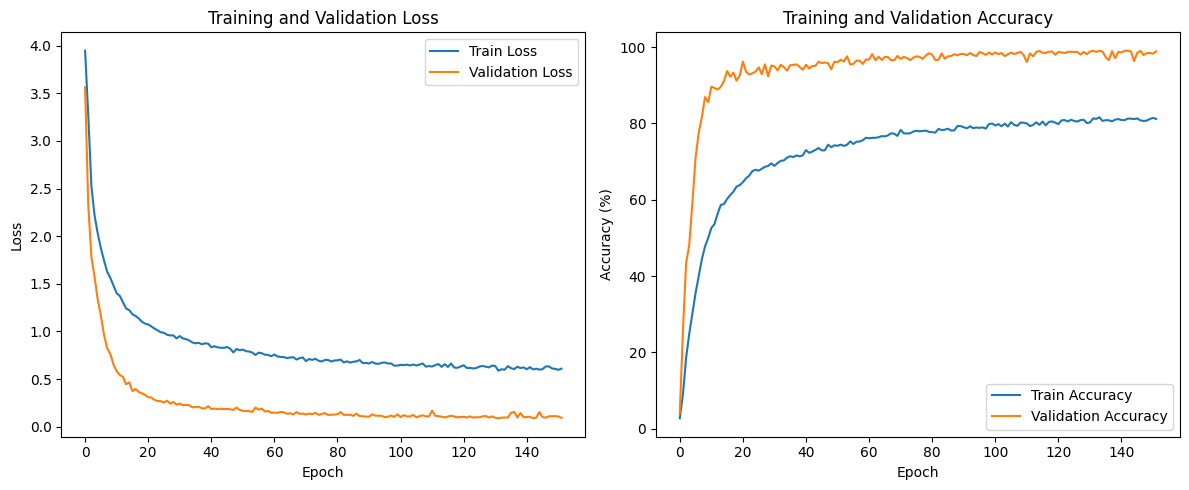

In [117]:
plt.figure(figsize=(12, 5))

# ---- loss ----
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ---- accuracy ----
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [118]:
# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/rssi_csi_best_model_0522_no_std_rssi32_aug_005.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for amp_inputs, rssi_input, labels in test_loader:
        amp_inputs, rssi_inputs, labels = amp_inputs.to(device), rssi_input.to(device), labels.to(device)
        outputs = model(amp_inputs, rssi_inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
            
        test_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        # 儲存真實標籤與預測標籤
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")

📊 測試損失: 0.4855, 測試準確率: 99.02%


In [119]:
import numpy as np
adjusted_labels = np.array(all_labels) + 1
adjusted_predictions = np.array(all_predictions) + 1
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Warning: Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) if errors else None

COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),

    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),

    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),

    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),

    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

mean_error = compute_mean_distance_error(adjusted_labels, adjusted_predictions, COORDINATES)
print("Mean distance error:", mean_error)


Mean distance error: 0.030768533821913406


# gated

In [77]:
class CSIRSSIClassifierGated(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSIClassifierGated, self).__init__()
        # --- CSI 分支 ---
        self.conv1 = nn.Conv1d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(128 * 12, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)

        # --- RSSI 分支 ---
        self.fc_rssi1 = nn.Linear(rssi_dim, 32)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(32, 64)
        self.dropout_rssi2 = nn.Dropout(0.5)

        # --- 門控融合 ---
        self.gate_fc = nn.Sequential(
            nn.Linear(64 + 64, 1),
            nn.Sigmoid()
        )

        # --- 分類層 ---
        self.fc_final1 = nn.Linear(64, 64)
        self.dropout_merge = nn.Dropout(0.5)
        self.fc_final2 = nn.Linear(64, num_classes)

    def forward(self, csi_input, rssi_input):
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = self.pool1(F.relu(self.bn1(self.conv1(csi_input))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.fc1(x)))
        csi_feat = self.dropout2(F.relu(self.fc2(x)))  # shape: (batch, 64)

        rssi_feat = self.dropout_rssi1(F.relu(self.fc_rssi1(rssi_input)))
        rssi_feat = self.dropout_rssi2(F.relu(self.fc_rssi2(rssi_feat)))  # shape: (batch, 8)

        fusion = torch.cat((csi_feat, rssi_feat), dim=1)  # shape: (batch, 72)
        gate = self.gate_fc(fusion)                      # shape: (batch, 1)
        gated_fusion = gate * csi_feat + (1 - gate) * rssi_feat.repeat(1, 8)  # 將 8 維 rssi 擴展成 64 維

        x = self.dropout_merge(F.relu(self.fc_final1(gated_fusion)))
        out = self.fc_final2(x)
        return out


In [78]:
import torch.nn as nn
import torch.optim as optim

# 損失函數
criterion = nn.CrossEntropyLoss()

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 學習率調整器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import torch
import matplotlib.pyplot as plt

# 儲存最佳模型相關設定
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_0520_no_std_rssi.pth"

# 訓練參數
epochs = 200

# Early Stopping 參數
patience = 20
counter = 0  

# 紀錄訓練過程中的 loss 和 accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # ---- 訓練階段 ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    # 注意：這裡每個 batch 返回三個項目：CSI (amp)、RSSI 與 labels
    for amp_inputs, rssi_inputs, labels in train_loader:
        # 將資料移到 device 上
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # 傳入兩個輸入到模型 (CSI 與 RSSI)
        outputs = model(amp_inputs, rssi_inputs)
        
        # CrossEntropyLoss 需要 target 為 class index
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
        
        # 更新訓練 loss 與正確數
        train_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    # ---- 驗證階段 ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(amp_inputs, rssi_inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            
            val_loss += loss.item() * amp_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    # 紀錄每個 epoch 的數值
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # 輸出當前 epoch 的結果
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # 儲存最佳模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("訓練完成！")


Epoch [1/200] | Train Loss: 3.6115 | Train Acc: 5.94% | Val Loss: 2.6704 | Val Acc: 22.08%
✅ 儲存最佳模型 (Val Loss: 2.6704) 至 ./models_save/rssi_csi_cls_gated_0521_no_std_rssi64.pth
Epoch [2/200] | Train Loss: 2.6853 | Train Acc: 16.14% | Val Loss: 1.8979 | Val Acc: 41.73%
✅ 儲存最佳模型 (Val Loss: 1.8979) 至 ./models_save/rssi_csi_cls_gated_0521_no_std_rssi64.pth
Epoch [3/200] | Train Loss: 2.2674 | Train Acc: 23.84% | Val Loss: 1.5910 | Val Acc: 49.10%
✅ 儲存最佳模型 (Val Loss: 1.5910) 至 ./models_save/rssi_csi_cls_gated_0521_no_std_rssi64.pth
Epoch [4/200] | Train Loss: 1.9910 | Train Acc: 30.49% | Val Loss: 1.2306 | Val Acc: 65.29%
✅ 儲存最佳模型 (Val Loss: 1.2306) 至 ./models_save/rssi_csi_cls_gated_0521_no_std_rssi64.pth
Epoch [5/200] | Train Loss: 1.8429 | Train Acc: 35.31% | Val Loss: 1.2417 | Val Acc: 65.06%
Epoch [6/200] | Train Loss: 1.7404 | Train Acc: 37.89% | Val Loss: 1.0315 | Val Acc: 69.73%
✅ 儲存最佳模型 (Val Loss: 1.0315) 至 ./models_save/rssi_csi_cls_gated_0521_no_std_rssi64.pth
Epoch [7/200] | Tra

# 雙輸出

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary  # torchinfo 可用來顯示多輸入模型摘要
import matplotlib.pyplot as plt

# -----------------------
# 模型定義：CSIRSSI_DualHead
# -----------------------
class CSIRSSI_DualHead(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSI_DualHead, self).__init__()
        # ---- CSI 分支 (CNN) ---
        # 假設輸入 CSI shape 為 (batch, 1, 48)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # 輸入長度 48 → 經過兩次 pooling → 48/2=24，再 24/2=12
        self.flatten_dim = 128 * 12
        
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        # 此時 CSI 分支輸出 64 維特徵
        
        # ---- RSSI 分支 (MLP) ----
        self.fc_rssi1 = nn.Linear(rssi_dim, 32)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(32, 32)
        self.dropout_rssi2 = nn.Dropout(0.5)
        # RSSI 分支輸出 32 維特徵
        
        # ---- 融合層 ----
        # 將 CSI (64-d) 與 RSSI (32-d) 連接 → 96-d
        self.fc_fusion = nn.Linear(64+32, 64)
        self.dropout_fusion = nn.Dropout(0.3)
        
        # ---- 雙輸出頭 ----
        # 分類頭：輸出 num_classes 個類別的 logits
        self.fc_class = nn.Linear(64, num_classes)
        # 回歸頭：輸出 2 個數值 (X, Y)
        self.fc_reg = nn.Linear(64, 2)
    
    def forward(self, csi_input, rssi_input):
        # CSI 分支
        # 如果輸入為 (batch, 48)，則擴展成 (batch, 1, 48)
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # flatten → (batch, flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        csi_feat = F.relu(self.fc2(x))
        csi_feat = self.dropout2(csi_feat)
        
        # RSSI 分支
        rssi_feat = F.relu(self.fc_rssi1(rssi_input))
        rssi_feat = self.dropout_rssi1(rssi_feat)
        rssi_feat = F.relu(self.fc_rssi2(rssi_feat))
        rssi_feat = self.dropout_rssi2(rssi_feat)
        
        # 融合特徵
        fusion = torch.cat([csi_feat, rssi_feat], dim=1)  # (batch, 96)
        fusion = F.relu(self.fc_fusion(fusion))
        fusion = self.dropout_fusion(fusion)
        
        # 雙輸出頭
        class_out = self.fc_class(fusion)  # 分類輸出 (batch, num_classes)
        reg_out = self.fc_reg(fusion)       # 回歸輸出 (batch, 2)
        
        return class_out, reg_out

# -----------------------
# 模型初始化與摘要
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSIRSSI_DualHead(num_classes=49, rssi_dim=4).to(device)

print("模型摘要:")
summary(model, input_data=(torch.randn(1, 1, 48).to(device), torch.randn(1, 4).to(device)))


模型摘要:


Layer (type:depth-idx)                   Output Shape              Param #
CSIRSSI_DualHead                         [1, 49]                   --
├─Conv1d: 1-1                            [1, 64, 48]               256
├─BatchNorm1d: 1-2                       [1, 64, 48]               128
├─MaxPool1d: 1-3                         [1, 64, 24]               --
├─Conv1d: 1-4                            [1, 128, 24]              24,704
├─BatchNorm1d: 1-5                       [1, 128, 24]              256
├─MaxPool1d: 1-6                         [1, 128, 12]              --
├─Linear: 1-7                            [1, 128]                  196,736
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 64]                   8,256
├─Dropout: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 32]                   160
├─Dropout: 1-12                          [1, 32]                   --

## 自定義apha

In [80]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)
alpha = 0.5  # 回歸損失權重，可根據需要調整

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# -----------------------
# COORDINATES 字典：將分類標籤轉為 (X, Y) 座標
# -----------------------
COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# -----------------------
# 訓練參數與 Early Stopping 設定
# -----------------------
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_0521_reg_class_05_nostd_rssi32_aug005.pth"
epochs = 300
patience = 20
counter = 0  

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------
# 訓練迴圈 (分類與回歸雙輸出)
# -----------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_class_loss = 0.0
    train_reg_loss = 0.0
    train_correct = 0
    total_train = 0

    # 每個 batch 返回 (amp_inputs, rssi_inputs, labels)
    # 其中 labels 為 one-hot 編碼 (用以計算分類損失)
    for amp_inputs, rssi_inputs, labels in train_loader:
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_out, reg_out = model(amp_inputs, rssi_inputs)
        
        # 分類目標：one-hot -> class index
        target_class = torch.argmax(labels, dim=1)
        loss_class = criterion(class_out, target_class)
        
        # 回歸目標：根據 target_class 透過 COORDINATES 字典取得 (X, Y) 座標
        true_coords = labels_to_coords(target_class, COORDINATES)
        loss_reg = criterion_reg(reg_out, true_coords)
        
        loss = loss_class + alpha * loss_reg
        loss.backward()
        optimizer.step()
        
        batch_size_curr = amp_inputs.size(0)
        train_loss += loss.item() * batch_size_curr
        train_class_loss += loss_class.item() * batch_size_curr
        train_reg_loss += loss_reg.item() * batch_size_curr
        _, predicted = torch.max(class_out, 1)
        total_train += batch_size_curr
        train_correct += (predicted == target_class).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_class_loss = train_class_loss / len(train_loader.dataset)
    avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    model.eval()
    val_loss = 0.0
    val_class_loss = 0.0
    val_reg_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            class_out, reg_out = model(amp_inputs, rssi_inputs)
            target_class = torch.argmax(labels, dim=1)
            loss_class = criterion(class_out, target_class)
            true_coords = labels_to_coords(target_class, COORDINATES)
            loss_reg = criterion_reg(reg_out, true_coords)
            loss = loss_class + alpha * loss_reg
            
            batch_size_curr = amp_inputs.size(0)
            val_loss += loss.item() * batch_size_curr
            val_class_loss += loss_class.item() * batch_size_curr
            val_reg_loss += loss_reg.item() * batch_size_curr
            _, predicted = torch.max(class_out, 1)
            total_val += batch_size_curr
            val_correct += (predicted == target_class).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_class_loss = val_class_loss / len(val_loader.dataset)
    avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_class_loss:.4f}, Reg: {avg_train_reg_loss:.4f}) | "
          f"Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} (Cls: {avg_val_class_loss:.4f}, Reg: {avg_val_reg_loss:.4f}) | "
          f"Val Acc: {val_acc:.2f}%")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("訓練完成！")


/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/300] | Train Loss: 6.2515 (Cls: 3.5434, Reg: 5.4161) | Train Acc: 9.53% || Val Loss: 3.9222 (Cls: 2.1471, Reg: 3.5502) | Val Acc: 36.63%
✅ 儲存最佳模型 (Val Loss: 3.9222) 至 ./models_save/rssi_csi_0521_reg_class_05_nostd_rssi32_aug005.pth
Epoch [2/300] | Train Loss: 3.7535 (Cls: 1.9201, Reg: 3.6669) | Train Acc: 37.13% || Val Loss: 1.7323 (Cls: 0.8134, Reg: 1.8379) | Val Acc: 83.41%
✅ 儲存最佳模型 (Val Loss: 1.7323) 至 ./models_save/rssi_csi_0521_reg_class_05_nostd_rssi32_aug005.pth
Epoch [3/300] | Train Loss: 2.5138 (Cls: 1.1533, Reg: 2.7211) | Train Acc: 61.05% || Val Loss: 1.1783 (Cls: 0.4148, Reg: 1.5269) | Val Acc: 92.08%
✅ 儲存最佳模型 (Val Loss: 1.1783) 至 ./models_save/rssi_csi_0521_reg_class_05_nostd_rssi32_aug005.pth
Epoch [4/300] | Train Loss: 1.9852 (Cls: 0.8508, Reg: 2.2688) | Train Acc: 71.31% || Val Loss: 0.9002 (Cls: 0.2721, Reg: 1.2562) | Val Acc: 94.96%
✅ 儲存最佳模型 (Val Loss: 0.9002) 至 ./models_save/rssi_csi_0521_reg_class_05_nostd_rssi32_aug005.pth
Epoch [5/300] | Train Loss: 1.690

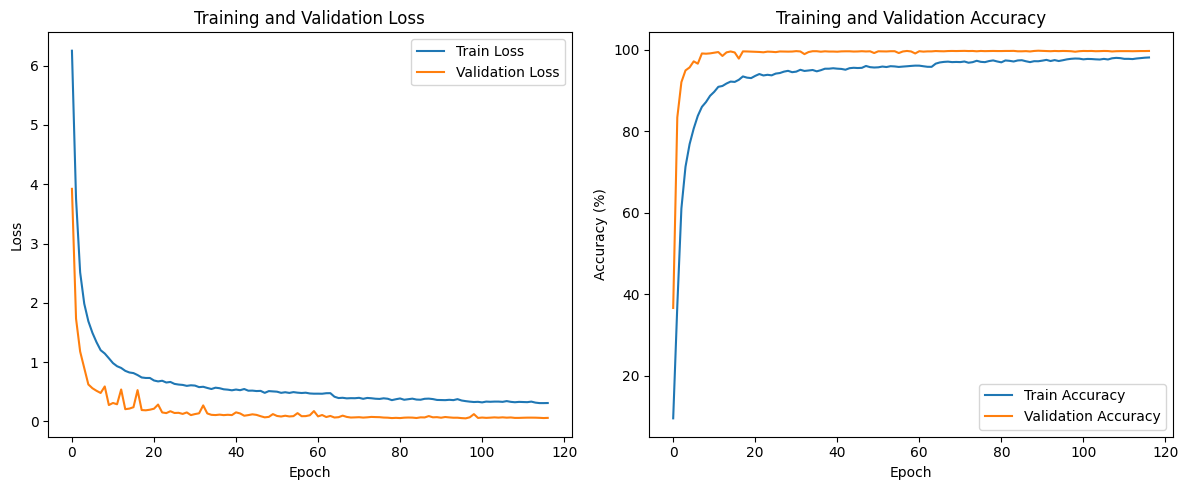

In [81]:
plt.figure(figsize=(12, 5))

# ---- loss ----
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ---- accuracy ----
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)

# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/rssi_csi_0521_reg_class_05_nostd_rssi32_aug005.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
all_reg = []

with torch.no_grad():
    for amp_inputs, rssi_input, labels in test_loader:
        amp_inputs, rssi_inputs, labels = amp_inputs.to(device), rssi_input.to(device), labels.to(device)
        outputs, reg = model(amp_inputs, rssi_inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
            
        test_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        # 儲存真實標籤與預測標籤
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_reg.extend(reg.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")

📊 測試損失: 0.2423, 測試準確率: 99.67%


In [83]:
import numpy as np
adjusted_predictions = np.array(all_predictions) + 1
adjusted_labels = np.array(all_labels) + 1
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , errors

mean_error, errors = compute_mean_distance_error(adjusted_labels, adjusted_predictions, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.010488759433515297


In [84]:
for i in errors:
    if i > 0:
        print(i)

3.059411708155671
1.2000000000000002
6.029925372672534
0.8485281374238568
3.49857113690718
1.8000000000000003
6.029925372672534
3.2310988842807027


STD前

In [55]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)
alpha = 0.7   # 回歸損失權重，可根據需要調整

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# -----------------------
# COORDINATES 字典：將分類標籤轉為 (X, Y) 座標
# -----------------------
COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# -----------------------
# 訓練參數與 Early Stopping 設定
# -----------------------
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_no_ppstd_07.pth"
epochs = 200
patience = 20
counter = 0  

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------
# 訓練迴圈 (分類與回歸雙輸出)
# -----------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_class_loss = 0.0
    train_reg_loss = 0.0
    train_correct = 0
    total_train = 0

    # 每個 batch 返回 (amp_inputs, rssi_inputs, labels)
    # 其中 labels 為 one-hot 編碼 (用以計算分類損失)
    for amp_inputs, rssi_inputs, labels in train_loader:
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_out, reg_out = model(amp_inputs, rssi_inputs)
        
        # 分類目標：one-hot -> class index
        target_class = torch.argmax(labels, dim=1)
        loss_class = criterion(class_out, target_class)
        
        # 回歸目標：根據 target_class 透過 COORDINATES 字典取得 (X, Y) 座標
        true_coords = labels_to_coords(target_class, COORDINATES)
        loss_reg = criterion_reg(reg_out, true_coords)
        
        loss = loss_class + alpha * loss_reg
        loss.backward()
        optimizer.step()
        
        batch_size_curr = amp_inputs.size(0)
        train_loss += loss.item() * batch_size_curr
        train_class_loss += loss_class.item() * batch_size_curr
        train_reg_loss += loss_reg.item() * batch_size_curr
        _, predicted = torch.max(class_out, 1)
        total_train += batch_size_curr
        train_correct += (predicted == target_class).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_class_loss = train_class_loss / len(train_loader.dataset)
    avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    model.eval()
    val_loss = 0.0
    val_class_loss = 0.0
    val_reg_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            class_out, reg_out = model(amp_inputs, rssi_inputs)
            target_class = torch.argmax(labels, dim=1)
            loss_class = criterion(class_out, target_class)
            true_coords = labels_to_coords(target_class, COORDINATES)
            loss_reg = criterion_reg(reg_out, true_coords)
            loss = loss_class + alpha * loss_reg
            
            batch_size_curr = amp_inputs.size(0)
            val_loss += loss.item() * batch_size_curr
            val_class_loss += loss_class.item() * batch_size_curr
            val_reg_loss += loss_reg.item() * batch_size_curr
            _, predicted = torch.max(class_out, 1)
            total_val += batch_size_curr
            val_correct += (predicted == target_class).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_class_loss = val_class_loss / len(val_loader.dataset)
    avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_class_loss:.4f}, Reg: {avg_train_reg_loss:.4f}) | "
          f"Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} (Cls: {avg_val_class_loss:.4f}, Reg: {avg_val_reg_loss:.4f}) | "
          f"Val Acc: {val_acc:.2f}%")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("訓練完成！")


Epoch [1/200] | Train Loss: 9.7290 (Cls: 4.5358, Reg: 7.4188) | Train Acc: 2.68% || Val Loss: 7.6072 (Cls: 3.7222, Reg: 5.5500) | Val Acc: 11.49%
✅ 儲存最佳模型 (Val Loss: 7.6072) 至 ./models_save/rssi_csi_no_ppstd_07.pth
Epoch [2/200] | Train Loss: 7.2355 (Cls: 3.5776, Reg: 5.2255) | Train Acc: 6.80% || Val Loss: 6.0366 (Cls: 3.0228, Reg: 4.3054) | Val Acc: 14.22%
✅ 儲存最佳模型 (Val Loss: 6.0366) 至 ./models_save/rssi_csi_no_ppstd_07.pth
Epoch [3/200] | Train Loss: 6.0965 (Cls: 3.0465, Reg: 4.3572) | Train Acc: 13.28% || Val Loss: 4.7671 (Cls: 2.4328, Reg: 3.3347) | Val Acc: 31.78%
✅ 儲存最佳模型 (Val Loss: 4.7671) 至 ./models_save/rssi_csi_no_ppstd_07.pth
Epoch [4/200] | Train Loss: 5.1379 (Cls: 2.6025, Reg: 3.6220) | Train Acc: 22.03% || Val Loss: 3.6670 (Cls: 1.8070, Reg: 2.6572) | Val Acc: 56.33%
✅ 儲存最佳模型 (Val Loss: 3.6670) 至 ./models_save/rssi_csi_no_ppstd_07.pth
Epoch [5/200] | Train Loss: 4.3309 (Cls: 2.1839, Reg: 3.0670) | Train Acc: 32.59% || Val Loss: 2.6883 (Cls: 1.3112, Reg: 1.9672) | Val Acc

In [56]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)

# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/rssi_csi_no_ppstd_07.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
all_reg = []

with torch.no_grad():
    for amp_inputs, rssi_input, labels in test_loader:
        amp_inputs, rssi_inputs, labels = amp_inputs.to(device), rssi_input.to(device), labels.to(device)
        outputs, reg = model(amp_inputs, rssi_inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
            
        test_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        # 儲存真實標籤與預測標籤
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_reg.extend(reg.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")

📊 測試損失: 0.1457, 測試準確率: 99.06%


In [57]:
import numpy as np
adjusted_predictions = np.array(all_predictions) + 1
adjusted_labels = np.array(all_labels) + 1
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , errors

mean_error, errors = compute_mean_distance_error(adjusted_labels, adjusted_predictions, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.031111988074222698


# std 後


In [474]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)
alpha = 0.7  # 回歸損失權重，可根據需要調整

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# -----------------------
# COORDINATES 字典：將分類標籤轉為 (X, Y) 座標
# -----------------------
COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# -----------------------
# 訓練參數與 Early Stopping 設定
# -----------------------
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_std.pth"
epochs = 200
patience = 20
counter = 0  

train_losses1 = []
val_losses1 = []
train_accuracies1 = []
val_accuracies1 = []

# -----------------------
# 訓練迴圈 (分類與回歸雙輸出)
# -----------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_class_loss = 0.0
    train_reg_loss = 0.0
    train_correct = 0
    total_train = 0

    # 每個 batch 返回 (amp_inputs, rssi_inputs, labels)
    # 其中 labels 為 one-hot 編碼 (用以計算分類損失)
    for amp_inputs, rssi_inputs, labels in train_loader:
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_out, reg_out = model(amp_inputs, rssi_inputs)
        
        # 分類目標：one-hot -> class index
        target_class = torch.argmax(labels, dim=1)
        loss_class = criterion(class_out, target_class)
        
        # 回歸目標：根據 target_class 透過 COORDINATES 字典取得 (X, Y) 座標
        true_coords = labels_to_coords(target_class, COORDINATES)
        loss_reg = criterion_reg(reg_out, true_coords)
        
        loss = loss_class + alpha * loss_reg
        loss.backward()
        optimizer.step()
        
        batch_size_curr = amp_inputs.size(0)
        train_loss += loss.item() * batch_size_curr
        train_class_loss += loss_class.item() * batch_size_curr
        train_reg_loss += loss_reg.item() * batch_size_curr
        _, predicted = torch.max(class_out, 1)
        total_train += batch_size_curr
        train_correct += (predicted == target_class).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_class_loss = train_class_loss / len(train_loader.dataset)
    avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    model.eval()
    val_loss = 0.0
    val_class_loss = 0.0
    val_reg_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            class_out, reg_out = model(amp_inputs, rssi_inputs)
            target_class = torch.argmax(labels, dim=1)
            loss_class = criterion(class_out, target_class)
            true_coords = labels_to_coords(target_class, COORDINATES)
            loss_reg = criterion_reg(reg_out, true_coords)
            loss = loss_class + alpha * loss_reg
            
            batch_size_curr = amp_inputs.size(0)
            val_loss += loss.item() * batch_size_curr
            val_class_loss += loss_class.item() * batch_size_curr
            val_reg_loss += loss_reg.item() * batch_size_curr
            _, predicted = torch.max(class_out, 1)
            total_val += batch_size_curr
            val_correct += (predicted == target_class).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_class_loss = val_class_loss / len(val_loader.dataset)
    avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    train_losses1.append(avg_train_loss)
    val_losses1.append(avg_val_loss)
    train_accuracies1.append(train_acc)
    val_accuracies1.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_class_loss:.4f}, Reg: {avg_train_reg_loss:.4f}) | "
          f"Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} (Cls: {avg_val_class_loss:.4f}, Reg: {avg_val_reg_loss:.4f}) | "
          f"Val Acc: {val_acc:.2f}%")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    # if counter >= patience:
    #     print(f"Early stop at epoch {epoch+1}")
    #     break

print("訓練完成！")

Epoch [1/200] | Train Loss: 8.9381 (Cls: 4.2722, Reg: 6.6655) | Train Acc: 2.90% || Val Loss: 7.1531 (Cls: 3.5513, Reg: 5.1454) | Val Acc: 8.53%
✅ 儲存最佳模型 (Val Loss: 7.1531) 至 ./models_save/rssi_csi_std.pth
Epoch [2/200] | Train Loss: 6.6720 (Cls: 3.4335, Reg: 4.6264) | Train Acc: 8.35% || Val Loss: 5.0249 (Cls: 2.7151, Reg: 3.2998) | Val Acc: 36.61%
✅ 儲存最佳模型 (Val Loss: 5.0249) 至 ./models_save/rssi_csi_std.pth
Epoch [3/200] | Train Loss: 5.4175 (Cls: 2.8094, Reg: 3.7260) | Train Acc: 18.77% || Val Loss: 3.7352 (Cls: 1.9663, Reg: 2.5271) | Val Acc: 55.12%
✅ 儲存最佳模型 (Val Loss: 3.7352) 至 ./models_save/rssi_csi_std.pth
Epoch [4/200] | Train Loss: 4.5681 (Cls: 2.3209, Reg: 3.2103) | Train Acc: 29.25% || Val Loss: 3.0024 (Cls: 1.4407, Reg: 2.2310) | Val Acc: 71.02%
✅ 儲存最佳模型 (Val Loss: 3.0024) 至 ./models_save/rssi_csi_std.pth
Epoch [5/200] | Train Loss: 3.9615 (Cls: 1.9495, Reg: 2.8743) | Train Acc: 38.77% || Val Loss: 2.2602 (Cls: 1.1016, Reg: 1.6552) | Val Acc: 82.27%
✅ 儲存最佳模型 (Val Loss: 2.26

In [30]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)

# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/rssi_csi_no_ppstd_01.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
all_reg = []

with torch.no_grad():
    for amp_inputs, rssi_input, labels in test_loader:
        amp_inputs, rssi_inputs, labels = amp_inputs.to(device), rssi_input.to(device), labels.to(device)
        outputs, reg = model(amp_inputs, rssi_inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
            
        test_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        # 儲存真實標籤與預測標籤
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_reg.extend(reg.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")

📊 測試損失: 0.0703, 測試準確率: 99.43%


In [31]:
import numpy as np
adjusted_predictions = np.array(all_predictions) + 1
adjusted_labels = np.array(all_labels) + 1
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , errors

mean_error, errors = compute_mean_distance_error(adjusted_labels, adjusted_predictions, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.018898624654228723


## LOSS & ACCURACY CURVE

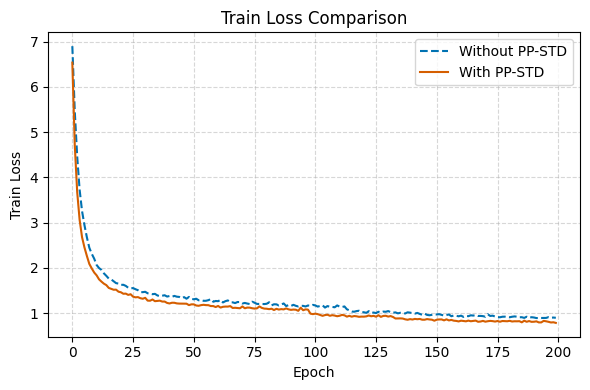

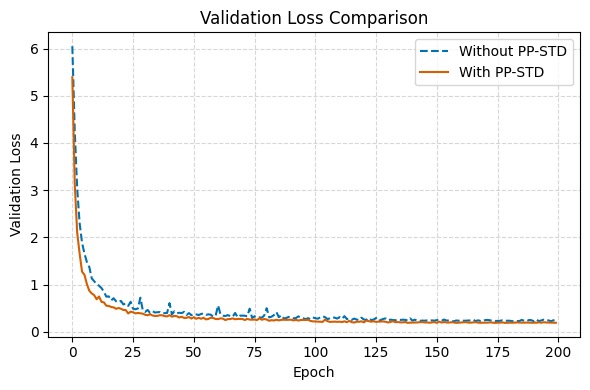

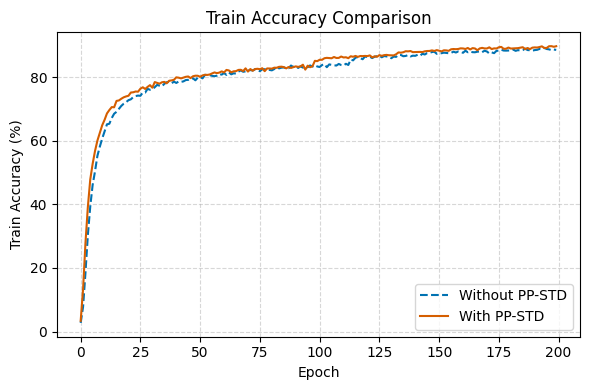

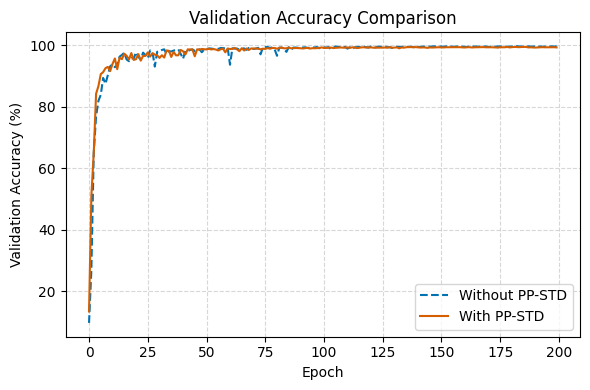

In [78]:
import matplotlib.pyplot as plt

# 色盲安全配色
colors = {
    'blue': '#0072B2',
    'orange': '#D55E00'
}

# ----- Train Loss -----
plt.figure(figsize=(6, 4))
plt.plot(train_losses[:200], label='Without PP-STD', color=colors['blue'], linestyle='--')
plt.plot(train_losses1[:200], label='With PP-STD', color=colors['orange'], linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ----- Validation Loss -----
plt.figure(figsize=(6, 4))
plt.plot(val_losses[:200], label='Without PP-STD', color=colors['blue'], linestyle='--')
plt.plot(val_losses1[:200], label='With PP-STD', color=colors['orange'], linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ----- Train Accuracy -----
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies[:200], label='Without PP-STD', color=colors['blue'], linestyle='--')
plt.plot(train_accuracies1[:200], label='With PP-STD', color=colors['orange'], linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy (%)')
plt.title('Train Accuracy Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ----- Validation Accuracy -----
plt.figure(figsize=(6, 4))
plt.plot(val_accuracies[:200], label='Without PP-STD', color=colors['blue'], linestyle='--')
plt.plot(val_accuracies1[:200], label='With PP-STD', color=colors['orange'], linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

NameError: name 'val_accuracies1' is not defined

## 動態調整

In [349]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)
#alpha = 0.1
k = 0.4  # 基礎平衡係數
min_alpha = 0.01
max_alpha = 0.5

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# -----------------------
# COORDINATES 字典：將分類標籤轉為 (X, Y) 座標
# -----------------------
COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# -----------------------
# 訓練參數與 Early Stopping 設定
# -----------------------
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_best_model_0324_reg_class_std_balance_04_05.pth"
epochs = 300
patience = 25
counter = 0  

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------
# 訓練迴圈 (分類與回歸雙輸出)
# -----------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_class_loss = 0.0
    train_reg_loss = 0.0
    train_correct = 0
    total_train = 0

    # 每個 batch 返回 (amp_inputs, rssi_inputs, labels)
    # 其中 labels 為 one-hot 編碼 (用以計算分類損失)
    for amp_inputs, rssi_inputs, labels in train_loader:
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_out, reg_out = model(amp_inputs, rssi_inputs)
        
        # 分類目標：one-hot -> class index
        target_class = torch.argmax(labels, dim=1)
        loss_class = criterion(class_out, target_class)
        
        # 回歸目標：根據 target_class 透過 COORDINATES 字典取得 (X, Y) 座標
        true_coords = labels_to_coords(target_class, COORDINATES)
        loss_reg = criterion_reg(reg_out, true_coords)
        
        loss = loss_class + alpha * loss_reg
        loss.backward()
        optimizer.step()
        
        batch_size_curr = amp_inputs.size(0)
        train_loss += loss.item() * batch_size_curr
        train_class_loss += loss_class.item() * batch_size_curr
        train_reg_loss += loss_reg.item() * batch_size_curr
        _, predicted = torch.max(class_out, 1)
        total_train += batch_size_curr
        train_correct += (predicted == target_class).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_class_loss = train_class_loss / len(train_loader.dataset)
    avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    model.eval()
    val_loss = 0.0
    val_class_loss = 0.0
    val_reg_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            class_out, reg_out = model(amp_inputs, rssi_inputs)
            target_class = torch.argmax(labels, dim=1)
            loss_class = criterion(class_out, target_class)
            true_coords = labels_to_coords(target_class, COORDINATES)
            loss_reg = criterion_reg(reg_out, true_coords)
            
            # 計算平衡係數 alpha 每個 epoch 動態調整
            ratio = loss_class.item() / (loss_reg.item() + 1e-8)
            alpha = k / ratio
            alpha = max(min_alpha, min(max_alpha, alpha))
            loss = loss_class + alpha * loss_reg
            
            batch_size_curr = amp_inputs.size(0)
            val_loss += loss.item() * batch_size_curr
            val_class_loss += loss_class.item() * batch_size_curr
            val_reg_loss += loss_reg.item() * batch_size_curr
            _, predicted = torch.max(class_out, 1)
            total_val += batch_size_curr
            val_correct += (predicted == target_class).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_class_loss = val_class_loss / len(val_loader.dataset)
    avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_class_loss:.4f}, Reg: {avg_train_reg_loss:.4f}) | "
          f"Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} (Cls: {avg_val_class_loss:.4f}, Reg: {avg_val_reg_loss:.4f}) | "
          f"Val Acc: {val_acc:.2f}%")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("訓練完成！")


Epoch [1/300] | Train Loss: 4.3049 (Cls: 3.6159, Reg: 6.8894) | Train Acc: 7.10% || Val Loss: 4.7610 (Cls: 2.3101, Reg: 4.9019) | Val Acc: 34.10%
✅ 儲存最佳模型 (Val Loss: 4.7610) 至 ./models_save/rssi_csi_best_model_0324_reg_class_std_balance_04_05.pth
Epoch [2/300] | Train Loss: 4.7523 (Cls: 2.5035, Reg: 4.4975) | Train Acc: 21.13% || Val Loss: 2.7650 (Cls: 1.4652, Reg: 2.5995) | Val Acc: 60.86%
✅ 儲存最佳模型 (Val Loss: 2.7650) 至 ./models_save/rssi_csi_best_model_0324_reg_class_std_balance_04_05.pth
Epoch [3/300] | Train Loss: 3.5975 (Cls: 1.9118, Reg: 3.3713) | Train Acc: 37.73% || Val Loss: 2.1164 (Cls: 0.9867, Reg: 2.2595) | Val Acc: 77.22%
✅ 儲存最佳模型 (Val Loss: 2.1164) 至 ./models_save/rssi_csi_best_model_0324_reg_class_std_balance_04_05.pth
Epoch [4/300] | Train Loss: 3.0337 (Cls: 1.5650, Reg: 2.9375) | Train Acc: 48.55% || Val Loss: 1.5490 (Cls: 0.6672, Reg: 1.7636) | Val Acc: 86.88%
✅ 儲存最佳模型 (Val Loss: 1.5490) 至 ./models_save/rssi_csi_best_model_0324_reg_class_std_balance_04_05.pth
Epoch [5/

## 自定義apha 0.7最好

In [365]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)

# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/rssi_csi_best_model_0506_reg_class_07_std.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
all_reg = []

with torch.no_grad():
    for amp_inputs, rssi_input, labels in test_loader:
        amp_inputs, rssi_inputs, labels = amp_inputs.to(device), rssi_input.to(device), labels.to(device)
        outputs, reg = model(amp_inputs, rssi_inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
            
        test_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        # 儲存真實標籤與預測標籤
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_reg.extend(reg.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")

📊 測試損失: 0.0558, 測試準確率: 99.43%


In [361]:
import numpy as np
adjusted_predictions = np.array(all_predictions) + 1
adjusted_labels = np.array(all_labels) + 1
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , errors

mean_error, errors = compute_mean_distance_error(adjusted_labels, adjusted_predictions, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.012163687323484332


In [362]:
for i in errors:
    if i > 0.0:
        print(i)
        

1.8
1.2
1.2000000000000002
0.5999999999999996
1.7999999999999998
5.909314681077663
0.5999999999999996
1.3416407864998738
0.5999999999999999
1.7999999999999998
6.708203932499369
3.8418745424597094
0.5999999999999996
1.7999999999999998


In [ ]:
import numpy as np

def compute_mean_distance_error_reg(y_true, y_pred, coord_dict):
    """
    y_true: 一維的 NumPy 陣列，存放真實的標籤 (整數)
    y_pred: 二維的 NumPy 陣列，形狀 (N,2)，存放回歸輸出的 (X, Y) 座標
    coord_dict: dict, 將標籤轉換為 (X, Y) 座標，鍵應該為 1~49
    """
    errors = []
    # 假設 y_true[i] 對應於 y_pred[i]
    for true_label, pred_coord in zip(y_true, y_pred):
        # 若你的分類 head 輸出是 0~48，則需要將其轉成 1~49
        true_label = int(true_label) + 1  # 轉換 0-index 為 1-index
        if true_label not in coord_dict:
            continue
        true_coord = np.array(coord_dict[true_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) if errors else None

# 假設 all_labels 為真實分類標籤 (0-index, 例如 0 ~ 48)
# all_reg 為模型回歸輸出的座標 (shape: (N,2))
mean_distance_error = compute_mean_distance_error_reg(np.array(all_labels), np.array(all_reg), COORDINATES)
print("Mean Distance Error (Regression):", mean_distance_error)


Mean Distance Error (Regression): 0.5729004140644297


In [ ]:
sorted_errors = np.sort(errors1)

for error in sorted_errors:
    if error > 0:
        print(error.round(4))

0.6
1.2
1.2
1.6971
1.8
1.8
2.6833
3.0
3.0594
3.2311
3.6
5.4
5.4332
5.9397
6.2642
7.3239


# 以下為  MultiTaskUncertaintyLoss 測試

In [508]:
# LOSS REWEIGHT

# -----------------------
# 自適應多任務損失函數：Uncertainty-based Weighting
# -----------------------
class MultiTaskUncertaintyLoss(nn.Module):
    def __init__(self):
        super(MultiTaskUncertaintyLoss, self).__init__()
        self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_reg = nn.Parameter(torch.tensor(0.0))

    def forward(self, loss_cls, loss_reg):
        precision_cls = torch.exp(-self.log_sigma_cls)
        precision_reg = torch.exp(-self.log_sigma_reg)
        loss = precision_cls * loss_cls + precision_reg * loss_reg
        loss += self.log_sigma_cls + self.log_sigma_reg  # regularization term
        return loss


In [511]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion_cls = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)
criterion = MultiTaskUncertaintyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# -----------------------
# COORDINATES 字典：將分類標籤轉為 (X, Y) 座標
# -----------------------
COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# -----------------------
# 訓練參數與 Early Stopping 設定
# -----------------------
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_0521_reg_class_MTUL_nostd_rssi32.pth"
epochs = 300
patience = 20
counter = 0  

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------
# 訓練迴圈 (分類與回歸雙輸出)
# -----------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_class_loss = 0.0
    train_reg_loss = 0.0
    train_correct = 0
    total_train = 0

    # 每個 batch 返回 (amp_inputs, rssi_inputs, labels)
    # 其中 labels 為 one-hot 編碼 (用以計算分類損失)
    for amp_inputs, rssi_inputs, labels in train_loader:
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_out, reg_out = model(amp_inputs, rssi_inputs)
        
        # 分類目標：one-hot -> class index
        target_class = torch.argmax(labels, dim=1)
        loss_class = criterion_cls(class_out, target_class)
        
        # 回歸目標：根據 target_class 透過 COORDINATES 字典取得 (X, Y) 座標
        true_coords = labels_to_coords(target_class, COORDINATES)
        loss_reg = criterion_reg(reg_out, true_coords)
        
        loss = criterion(loss_class, loss_reg)
        loss.backward()
        optimizer.step()
        
        batch_size_curr = amp_inputs.size(0)
        train_loss += loss.item() * batch_size_curr
        train_class_loss += loss_class.item() * batch_size_curr
        train_reg_loss += loss_reg.item() * batch_size_curr
        _, predicted = torch.max(class_out, 1)
        total_train += batch_size_curr
        train_correct += (predicted == target_class).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_class_loss = train_class_loss / len(train_loader.dataset)
    avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    model.eval()
    val_loss = 0.0
    val_class_loss = 0.0
    val_reg_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            class_out, reg_out = model(amp_inputs, rssi_inputs)
            target_class = torch.argmax(labels, dim=1)
            loss_class = criterion_cls(class_out, target_class)
            true_coords = labels_to_coords(target_class, COORDINATES)
            loss_reg = criterion_reg(reg_out, true_coords)
            loss = loss_class + alpha * loss_reg
            
            batch_size_curr = amp_inputs.size(0)
            val_loss += loss.item() * batch_size_curr
            val_class_loss += loss_class.item() * batch_size_curr
            val_reg_loss += loss_reg.item() * batch_size_curr
            _, predicted = torch.max(class_out, 1)
            total_val += batch_size_curr
            val_correct += (predicted == target_class).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_class_loss = val_class_loss / len(val_loader.dataset)
    avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_class_loss:.4f}, Reg: {avg_train_reg_loss:.4f}) | "
          f"Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} (Cls: {avg_val_class_loss:.4f}, Reg: {avg_val_reg_loss:.4f}) | "
          f"Val Acc: {val_acc:.2f}%")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("訓練完成！")


/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/300] | Train Loss: 5.7598 (Cls: 2.4583, Reg: 3.3014) | Train Acc: 27.57% || Val Loss: 3.0014 (Cls: 1.2298, Reg: 1.7715) | Val Acc: 81.63%
✅ 儲存最佳模型 (Val Loss: 3.0014) 至 ./models_save/rssi_csi_0521_reg_class_MTUL_nostd_rssi32.pth
Epoch [2/300] | Train Loss: 3.8250 (Cls: 1.4312, Reg: 2.3938) | Train Acc: 55.12% || Val Loss: 1.6459 (Cls: 0.4913, Reg: 1.1545) | Val Acc: 94.55%
✅ 儲存最佳模型 (Val Loss: 1.6459) 至 ./models_save/rssi_csi_0521_reg_class_MTUL_nostd_rssi32.pth
Epoch [3/300] | Train Loss: 2.9902 (Cls: 0.9897, Reg: 2.0005) | Train Acc: 68.54% || Val Loss: 1.1354 (Cls: 0.2848, Reg: 0.8506) | Val Acc: 94.20%
✅ 儲存最佳模型 (Val Loss: 1.1354) 至 ./models_save/rssi_csi_0521_reg_class_MTUL_nostd_rssi32.pth
Epoch [4/300] | Train Loss: 2.5543 (Cls: 0.7860, Reg: 1.7683) | Train Acc: 75.17% || Val Loss: 1.2491 (Cls: 0.2470, Reg: 1.0021) | Val Acc: 95.80%
Epoch [5/300] | Train Loss: 2.2054 (Cls: 0.6512, Reg: 1.5542) | Train Acc: 79.40% || Val Loss: 1.0546 (Cls: 0.1761, Reg: 0.8785) | Val Acc: 96

In [512]:
# -----------------------
# 損失函數、優化器與學習率調整器設定
# -----------------------
criterion_cls = nn.CrossEntropyLoss()  # 分類損失：target 為 class index
criterion_reg = nn.MSELoss()         # 回歸損失：target 為 (X, Y)
criterion = MultiTaskUncertaintyLoss().to(device)
# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/rssi_csi_0521_reg_class_MTUL_nostd_rssi32.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
all_reg = []

with torch.no_grad():
    for amp_inputs, rssi_input, labels in test_loader:
        amp_inputs, rssi_inputs, labels = amp_inputs.to(device), rssi_input.to(device), labels.to(device)
        outputs, reg = model(amp_inputs, rssi_inputs)
        loss = criterion_cls(outputs, torch.argmax(labels, dim=1))
            
        test_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        # 儲存真實標籤與預測標籤
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_reg.extend(reg.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")

📊 測試損失: 0.0840, 測試準確率: 99.59%


In [515]:
import numpy as np
adjusted_predictions = np.array(all_predictions) + 1
adjusted_labels = np.array(all_labels) + 1
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) , errors

mean_error, errors = compute_mean_distance_error(adjusted_labels, adjusted_predictions, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.015009651128307246


# 重複測試

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader

def split_data(amp, rssi, rp_labels, seed=42, batch_size=32, augment=True, csi_noise_std=0.00, rssi_mask_prob=0.05):
    """
    切分資料為 7:2:1 並回傳 train/val/test DataLoader 與 encoder
    """
    indices = amp.index

    # 切分 70% 訓練 + 30% 臨時
    train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=seed)

    # 臨時中的 1/3 為 val，2/3 為 test → 最終 10% + 20%
    val_idx, test_idx = train_test_split(temp_idx, test_size=1/3, random_state=seed)

    # 根據 index 取出資料
    amp_train, amp_val, amp_test = amp.loc[train_idx], amp.loc[val_idx], amp.loc[test_idx]
    rssi_train, rssi_val, rssi_test = rssi.loc[train_idx], rssi.loc[val_idx], rssi.loc[test_idx]
    y_train, y_val, y_test = rp_labels.loc[train_idx], rp_labels.loc[val_idx], rp_labels.loc[test_idx]

    # One-hot 編碼
    encoder = OneHotEncoder(sparse_output=False)
    y_train_oh = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
    y_val_oh   = encoder.transform(np.array(y_val).reshape(-1, 1))
    y_test_oh  = encoder.transform(np.array(y_test).reshape(-1, 1))

    # 建立 Dataset
    train_dataset = CSIRSSIDataset(np.array(amp_train), np.array(rssi_train), y_train_oh,
                                   augment=augment, csi_noise_std=csi_noise_std, rssi_mask_prob=rssi_mask_prob)
    val_dataset   = CSIRSSIDataset(np.array(amp_val), np.array(rssi_val), y_val_oh)
    test_dataset  = CSIRSSIDataset(np.array(amp_test), np.array(rssi_test), y_test_oh)

    # 建立 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, encoder


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# 假設前面已經定義好：
# CSIRSSI_DualHead, labels_to_coords, compute_mean_distance_error
# train_loader, val_loader, test_loader, COORDINATES 等

# hyper-params
num_runs = 5
alpha = 0.2
epochs = 200
patience = 20
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 用來存結果
test_accs = []
test_mdes = []
test_wrong_errors = []

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # 1) 重置 model / optimizer / scheduler / early-stop
    model = CSIRSSI_DualHead(num_classes=49, rssi_dim=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=15, verbose=False
    )
    best_val_loss = float('inf')
    counter = 0

    # 2) 訓練
    for epoch in range(epochs):
        model.train()
        for amp_inputs, rssi_inputs, labels in train_loader:
            amp_inputs, rssi_inputs, labels = (
                amp_inputs.to(device),
                rssi_inputs.to(device),
                labels.to(device),
            )
            optimizer.zero_grad()
            class_out, reg_out = model(amp_inputs, rssi_inputs)

            target_class = torch.argmax(labels, dim=1)
            loss_class = nn.CrossEntropyLoss()(class_out, target_class)
            true_coords = labels_to_coords(target_class, COORDINATES)
            loss_reg = nn.MSELoss()(reg_out, true_coords)

            loss = loss_class + alpha * loss_reg
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for amp_inputs, rssi_inputs, labels in val_loader:
                amp_inputs, rssi_inputs, labels = (
                    amp_inputs.to(device),
                    rssi_inputs.to(device),
                    labels.to(device),
                )
                co, ro = model(amp_inputs, rssi_inputs)
                tc = torch.argmax(labels, dim=1)
                lc = nn.CrossEntropyLoss()(co, tc)
                rc = nn.MSELoss()(ro, labels_to_coords(tc, COORDINATES))
                val_loss += (lc + alpha * rc).item() * amp_inputs.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    # 3) 測試並計算指標
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in test_loader:
            amp_inputs, rssi_inputs, labels = (
                amp_inputs.to(device),
                rssi_inputs.to(device),
                labels.to(device),
            )
            co, _ = model(amp_inputs, rssi_inputs)
            preds = torch.argmax(co, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

    # +1 轉回 1~49
    y_true = np.array(all_labels) + 1
    y_pred = np.array(all_preds)  + 1
    acc = 100 * np.mean(y_true == y_pred)
    mde, errors = compute_mean_distance_error(y_true, y_pred, COORDINATES)

    test_accs.append(acc)
    test_mdes.append(mde)
    # 只保留錯誤樣本的 distance error (>0)
    wrong = [e for e in errors if e > 0]
    test_wrong_errors.append(wrong)

    print(f"Run {run+1}: test acc = {acc:.2f}%, test MDE = {mde:.4f}, wrong samples = {len(wrong)}")

# 4) 整理成 DataFrame，並存成 CSV
results = pd.DataFrame({
    'run': list(range(1, num_runs+1)),
    'accuracy': test_accs,
    'mde': test_mdes,
    'wrong_errors': test_wrong_errors
})

print("\n=== Summary ===")
print(results)

# 存檔
results.to_csv('./repeat/02/experiment_results02.csv', index=False)
print("Saved results to experiment_results.csv")



=== Run 1/5 ===


/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Run 1: test acc = 99.71%, test MDE = 0.0086, wrong samples = 7

=== Run 2/5 ===
Run 2: test acc = 99.63%, test MDE = 0.0154, wrong samples = 9

=== Run 3/5 ===
Run 3: test acc = 99.67%, test MDE = 0.0117, wrong samples = 8

=== Run 4/5 ===
Run 4: test acc = 99.67%, test MDE = 0.0119, wrong samples = 8

=== Run 5/5 ===
Run 5: test acc = 99.67%, test MDE = 0.0114, wrong samples = 8

=== Summary ===
   run   accuracy       mde                                       wrong_errors
0    1  99.714286  0.008574  [1.2000000000000002, 2.6832815729997477, 6.0, ...
1    2  99.632653  0.015438  [6.26418390534633, 1.2000000000000002, 6.70820...
2    3  99.673469  0.011713  [6.26418390534633, 1.2000000000000002, 5.36656...
3    4  99.673469  0.011892  [3.2310988842807027, 1.2000000000000002, 4.242...
4    5  99.673469  0.011404  [3.2310988842807027, 1.2000000000000002, 6.462...
Saved results to experiment_results.csv
